# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [3]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
import time
from math import ceil
from scipy.io.wavfile import write
from scipy import signal
import scipy

## Functions

In [4]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [5]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [6]:
wavefile = wave.open(sound, 'rb')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [7]:
play = False
if play :
    play_sound(sound) 

In [8]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [9]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

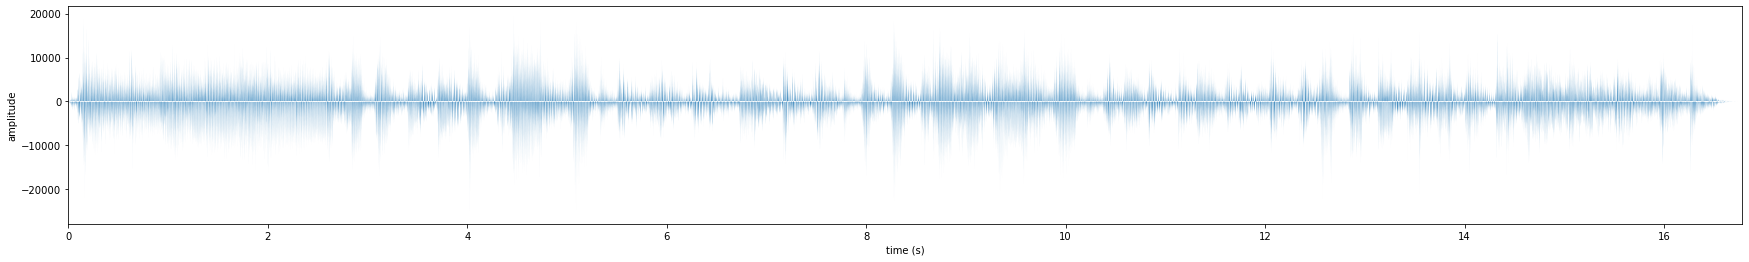

In [10]:
plot_sound(x, times)

In [11]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [12]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [13]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))], w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

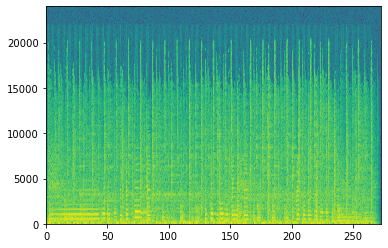

In [14]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,int(L)),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

In [15]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

# I. Conversion of sampling rate

In [16]:
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 10)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

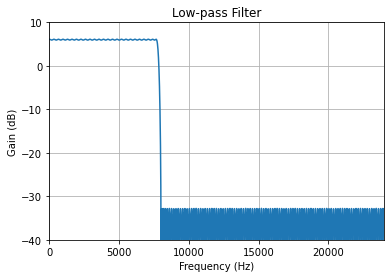

In [17]:
fs = 48000    # Sample rate, Hz
cutoff = fs*1/6 - 300    # Desired cutoff frequency, Hz
trans_width = 300  # Width of transition from pass band to stop band, Hz
numtaps = 300      # Size of the FIR filter.
h = scipy.signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [2, 0], Hz=fs)
w, H = scipy.signal.freqz(h, [1], worN=2000)
plot_response(fs, w, H, "Low-pass Filter")

### Implementing this conversion

We want to resample by a factor of 2/3.

#### Upsampling by factor L=2

We first do the insertion operator by creating a new array which represents x with L-1 zeros between each value.

In [30]:
def insertion(L, x):
    w = [0 for i in range(len(x) * L)]
    for n in range(len(x)):
        w[n*L] = x[n]
    return w

In [31]:
L = 2
w = insertion(L, x)

Then we apply the filter to the new signal w.

In [20]:
y_tmp = signal.lfilter(h, [1], w)

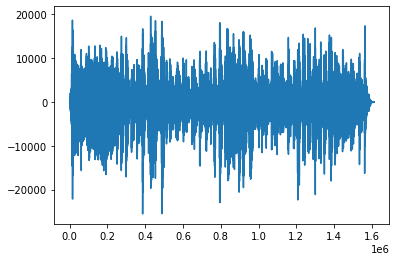

In [21]:
plt.plot(y_tmp)

#### Downsampling by factor M=3

We do the reverse operations.

First, we apply a new operator.

In [22]:
def porte(M, y_tmp):
    p = []
    for n in range(len(y_tmp)):
        tmp = [np.exp((2*1j*np.pi*k*n)/M) for k in range(M)]
        big_sum = np.sum(tmp)
        p.append((1/M) * big_sum)
    p = np.asarray(p)
    y_tmp = np.asarray(y_tmp)
    w_new = p*y_tmp
    return w_new

In [23]:
M = 3
w_new = porte(M, y_tmp)

Then we take one value of w_new over M.

In [24]:
def downSampling(M, y_tmp):
    return y_tmp[::M]

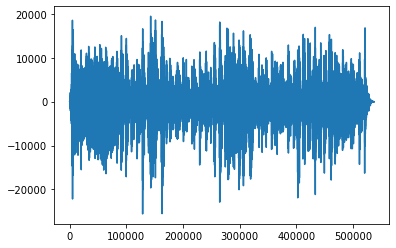

In [25]:
y = downSampling(M, w_new) 
plt.plot(y.real)

Une cellule pour voir le temps de calcul

16.690494060516357

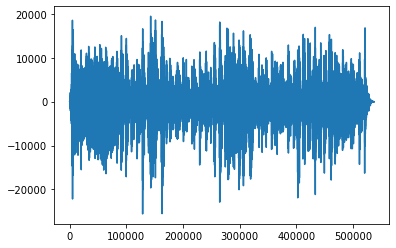

In [26]:
start_time = time.time()
L = 2
w = upSampling(L, x)
y_tmp = signal.lfilter(h, [1], w)
M = 3
w_new = porte(M, y_tmp)
y = downSampling(M, w_new) 
plt.plot(y.real)
time.time() - start_time

### Efficient conversion by using two successive polyphase decompositions

In [27]:
M = 3
L = 2

Type II polyphase components and type I polyphase components

In [29]:
r0 = h[L-1::L]
r1 = h[L-2::L]

e00 = r0[::3]
e01 = r0[1::3]
e02 = r0[2::3]

e10 = r1[::3]
e11 = r1[1::3]
e12 = r1[2::3]

Efficient structure 

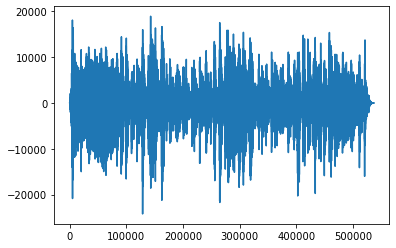

In [36]:
x0 = insertion(2, x) # insertion of 0

#Upsampling
x00 = np.convolve(x0, r0)
x00 = np.concatenate((x00[1:], np.zeros(1)))

#Suivi de downsampling
y00 = np.convolve(x00, e00)
x1 = np.concatenate((x00[1:], np.zeros(1)))
y01 = np.convolve(x1, e01)
x2 = np.concatenate((x00[2:], np.zeros(2)))
y02 = np.convolve(x2, e02)

y0 = y00 + y01 + y02
y0 = y0[::3]

#upsampling
x11 = np.convolve(x0, r1)
#downsampling
y10 = np.convolve(x11, e10)
x1 = np.concatenate((x11[1:], np.zeros(1)))
y11 = np.convolve(x1, e11)
x2 = np.concatenate((x11[2:], np.zeros(2)))
y12 = np.convolve(x2, e12)

y1 = y10 + y11 + y12
y1 = y1[::3]

y = y0 + y1

plt.plot(y)

Une cellule pour voir le temps d'execution

0.7798230648040771

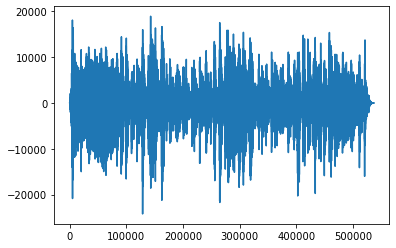

In [37]:
start_time = time.time()

r0 = h[L-1::L]
r1 = h[L-2::L]

e00 = r0[::3]
e01 = r0[1::3]
e02 = r0[2::3]

e10 = r1[::3]
e11 = r1[1::3]
e12 = r1[2::3]

x0 = insertion(2, x) # insertion of 0

#Upsampling
x00 = np.convolve(x0, r0)
x00 = np.concatenate((x00[1:], np.zeros(1)))

#Suivi de downsampling
y00 = np.convolve(x00, e00)
x1 = np.concatenate((x00[1:], np.zeros(1)))
y01 = np.convolve(x1, e01)
x2 = np.concatenate((x00[2:], np.zeros(2)))
y02 = np.convolve(x2, e02)

y0 = y00 + y01 + y02
y0 = y0[::3]

#upsampling
x11 = np.convolve(x0, r1)
#downsampling
y10 = np.convolve(x11, e10)
x1 = np.concatenate((x11[1:], np.zeros(1)))
y11 = np.convolve(x1, e11)
x2 = np.concatenate((x11[2:], np.zeros(2)))
y12 = np.convolve(x2, e12)

y1 = y10 + y11 + y12
y1 = y1[::3]

y = y0 + y1

plt.plot(y)

time.time() - start_time

The efficient structures is much more rapid. La différence est flagrante ! Plus de 15 fois plus vite !

# II. STFT audio equalization

## 1. STFT analysis

C:\Users\quent\AppData\Local\Temp\ipykernel_15656\2577999038.py:3: RuntimeWarning: divide by zero encountered in log
  response = 20 * np.log(np.abs(W))


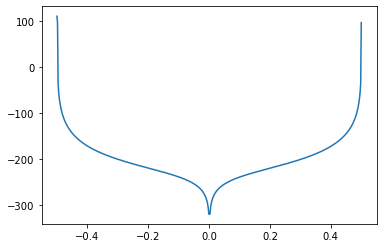

In [64]:
W = np.fft.fft(w, M)
freq = np.linspace(-0.5, 0.5, M)
response = 20 * np.log(np.abs(W))
plt.plot(freq, response)

In this notebook, the definition of the STFT refers to the band-pass convention because it's the signal x is translated and not the window.

#### Computation of the STFT with k=3 and M=32 and R=1

In [87]:
N = x.shape[0] # % longueur du signal
Nw = 4
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [88]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))], w) # calcul de la trame 
    X = np.fft.fft(tx, M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add
def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

Xtilde(3, u)

In [89]:
x3 = Xtilde[2,:]

In [90]:
np.sum(np.imag(x3))

127493248.79025473

This signal is complex.

 ...]

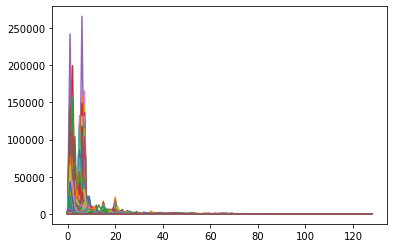

In [91]:
f, t, Sxx = signal.spectrogram(x, fs=48000)
plt.plot(Sxx)

C:\Users\quent\anaconda3\lib\site-packages\scipy\signal\spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


 ...]

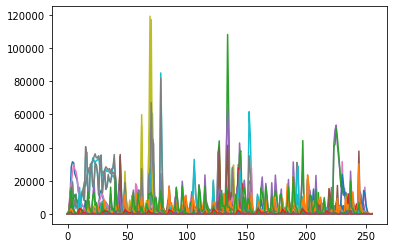

In [99]:
f, t, Sxx = signal.spectrogram(np.fft.ifft(x3))
plt.plot(Sxx)

## 2. Reconstruction

In [92]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w
         # OLA
    
    return output

In [93]:
R = 1
Nw = 4*R
hanning_window_squared = ola(np.hanning(Nw) ** 2, R)

In [94]:
hanning_window_squared

array([[0.    ],
       [0.5625],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [1.125 ],
       [0.5625],
       [0.    ]])

We remark that f(n) != 1 for every n, so taking ws=w doesn't work so well. However, it's rather good to make the resynthese with this window of synthesis.

#### Resynthese

In [108]:
h, w = Xtilde.shape

Ys = []
for u in range(w):
    ys = np.fft.ifft(Xtilde[:,u]) # On fait la tf inverse de Xtilde à l'instant u
    window = np.zeros(h)
    window[:Nw] = np.hanning(Nw)
    ys = np.multiply(ys, window) # On multiplie par une fenêtre de hanning
    Ys.append(ys)

In [120]:
Y = [0 for i in range(w)]
for n in range(w):
    for u in range(max(0, (n-31)//R),min(n//R, len(Ys))):
        if (n-u*R) > 31:
            continue
        Y[n] += Ys[u][n-u*R]

In [121]:
Y_real = [0 for i in range(len(Y))]
for i in range(len(Y)):
    Y_real[i] = Y[i].real

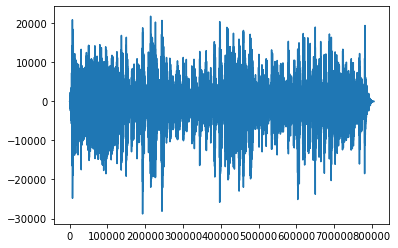

In [122]:
plt.plot(Y_real)